# Sequence specificities of RNA-binding proteins with convolutional neural networks

In this tutorial, we will walk through a simple tensorflow example of how to build, train, and evaluate a convolutional neural network for a common supervised learning regression task of predicting the sequence specificity of a RNA binding protein twoards RNA probe sequences in the RNAcompete dataset.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

## Intro to Convolutional Neural Networks

Convolutional neural networks (CNNs) are the current state-of-the-art model architecture for image classification tasks. Typically, a CNN is composed of a stack of convolutional modules that perform feature extraction. Each module consists of a convolutional layer followed by a pooling layer. The last convolutional module is followed by one or more dense layers that perform classification. The final dense layer in a CNN contains a single node for prediction in the model.

CNNs contains three main components:

* Convolutional layers:  apply a specified number of convolution filters to the image. For each subregion, the layer performs a set of mathematical operations to produce a single value in the output feature map. Convolutional layers then typically apply a ReLU activation function to the output to introduce nonlinearities into the model.

* Pooling layers: downsample the image data extracted by the convolutional layers to reduce the dimensionality of the feature map in order to decrease processing time. A commonly used pooling algorithm is max pooling, which extracts subregions of the feature map (e.g., 2x2-pixel tiles), keeps their maximum value, and discards all other values.

* Dense (fully connected) layers, which perform classification on the features extracted by the convolutional layers and downsampled by the pooling layers. In a dense layer, every node in the layer is connected to every node in the preceding layer.

For more details on CNNs:
https://cs231n.github.io/convolutional-networks/


## Dataset overview 

Here we will employ a CNN on experimental data from the RNAcompete dataset. The sequences were preprocessed by converting the sequences to a one-hot representation. We generated structural profiles of paired-unpaired probabilities for each nucleotide with RNAplfold.   The affinity intensities were normalized with a log-transformation (details are not important for this tutorial).  

Let's load the data:



In [2]:
# path to dataset 
data_file_path = '../data/VTS1.h5'

# load dataset
dataset = h5py.File(data_file_path, 'r')
X_train = np.array(dataset['X_train']).astype(np.float32)
Y_train = np.array(dataset['Y_train']).astype(np.float32)
X_valid = np.array(dataset['X_valid']).astype(np.float32)
Y_valid = np.array(dataset['Y_valid']).astype(np.float32)
X_test = np.array(dataset['X_test']).astype(np.float32)
Y_test = np.array(dataset['Y_test']).astype(np.float32)

X_train.shape

(37187, 39, 6)

Note that the training sequences (X_train) have a shape of [37187, 39, 6].  The sequence lengths are 39 (some are shorter but have been padded with zeros to make them all the same size).  The 6 represents the 4 nucleotide channels and 2 channels for paired and unpaired. 
Although tensorflow supports a 1D convolution function, tensorflow was designed with 2D images in mind, so there is way better support for the 2D functions.  We can use these 2D functions by adding another 'ornamental' dimension.  

In [3]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_valid = np.expand_dims(X_valid, axis=2)

# get shapes of data
num_data, seq_length, _, dims = X_train.shape

#### Reset graphs 

First, we need to reset the default graph to start with a fresh canvas.  Sometimes, you can have disjoint graphs when you forget that you created variables and ops, but then removed them without resetting the graph. 

In [4]:
tf.reset_default_graph()

# build our convolutional neural network model 

Our model will be similar to DeepBind: one convolutional layer, a max-pooling layer, one fully-connected hidden layer, followed by an output layer.  Note that the major difference between this CNN and the one for TFs is that here we need to perform a regression task.  So, the output activation is linear and the objective is now a squared_error.  

In [5]:
# functions for initializations also known as inits
def he_init(shape, fan_in):
    """He inits are designed for neural networks that employ ReLU activations."""
    fan_in = shape
    stddev = np.sqrt(2.6/fan_in)
    return tf.truncated_normal(shape=shape, mean=0.0, stddev=stddev, dtype=tf.float32)

def const_init(shape, value=0.0):
    """constant inits are useful for bias terms"""
    return tf.constant(shape=shape, value=value, dtype=tf.float32)

# create a placeholder for the data
inputs = tf.placeholder(tf.float32, shape=[None, seq_length, 1, dims], name='inputs')

# build the first convolutional layer
num_filters = 32
filter_size = 12
strides = 1
W1 = tf.Variable(he_init(shape=[filter_size, 1, dims, num_filters], fan_in=dims*seq_length), name='W1')
b1 = tf.Variable(const_init(shape=[num_filters], value=0.01), name='b1')
conv_1 = tf.nn.conv2d(inputs, 
                      filter=W1, 
                      strides=[1, strides, 1, 1], 
                      padding='VALID')

# add bias term
conv_1_bias = tf.nn.bias_add(conv_1, b1)

# perform activation
conv_1_active = tf.nn.relu(conv_1_bias)

# downsample data with max-pooling
pool_size = 10
conv_1_pool = tf.nn.max_pool(conv_1, 
                             ksize=(1,pool_size,1,1), 
                             strides=(1,pool_size,1,1), 
                             padding='SAME')

# add dropout -- note that keep prob is a placeholder.  
#This allows us to set different levels of dropout during training and testing
keep_prob_conv = tf.placeholder(tf.float32, name='keep_prob_conv')
conv_1_dropout = tf.nn.dropout(conv_1_pool, keep_prob=keep_prob_conv)

# get number of input neurons
num_incoming = np.prod(conv_1_dropout.get_shape()[1:]).value

# reshape convolutional outputs to a vector
conv_1_flat = tf.reshape(conv_1_dropout, shape=(-1,num_incoming))

# build a fully-connected layer (also known as a dense layer)
num_units = 128
W2 = tf.Variable(he_init(shape=[num_incoming, num_units], fan_in=num_incoming), name='W2')
b2 = tf.Variable(const_init(shape=[num_units], value=0.01), name='b2')
dense_1 = tf.matmul(conv_1_flat, W2)

# add bias term
dense_1_bias = tf.nn.bias_add(dense_1, b2)

# perform activation
dense_1_active = tf.nn.relu(dense_1_bias)


keep_prob_dense = tf.placeholder(tf.float32, name='keep_prob_dense')
dense_1_active_dropout = tf.nn.dropout(dense_1_active, keep_prob=keep_prob_dense)

# build a fully-connected layer (also known as a dense layer)
W3 = tf.Variable(he_init(shape=[num_units, 1], fan_in=num_units), name='W3')
b3 = tf.Variable(const_init(shape=[1], value=0.01), name='b3')
dense_2 = tf.matmul(dense_1_active_dropout, W3)

# add bias term
predictions = tf.nn.bias_add(dense_2, b3)

# define loss and build optimizer

For both training and evaluation, we need to define a loss function that measures how closely the model's predictions match the target classes. This is usually a log-likelihood function for supervised learning.  The log-likelihood for a linear regression is a mean-squared error, with some basic assumptions of course.  

We also need to be able to calculate the gradients of the loss function with respect to the parameters of the model, which is efficiently accomplished with backpropagation.  Then, we can update the weights with a scaled gradients, which is knownas gradient descent learning. 

Fortunately, tensorflow provides a nice wrappers to perform all of this with the tf.train API.  Within tf.train are numerous types of gradient descent optimizers, including traditional stochastic gradient descent (SGD), SGD with momentum, ADAGRAD, RMSPROP, ADAM, plus more.  We will use ADAM in this notebook.  

In [6]:
# instantiate placeholder for labels 
targets = tf.placeholder(tf.float32, shape=[None, 1], name='targets')

# calculate binary cross-entropy loss function
squared_error = tf.square(predictions - targets)
loss_function = tf.reduce_mean(squared_error)
    
# get a list of all trainable variables
trainable_vars = tf.trainable_variables()

# flatten and concatenate all parameters for L2/L1 regularization
all_params = []
for param in trainable_vars:
    all_params = tf.concat([all_params, tf.reshape(param, [-1,])], axis=0)
    
# calculate L2 regularization
l2_strength = 1e-6
loss_function += tf.reduce_sum(tf.square(all_params))*l2_strength

# setup optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0003, 
                                   beta1=0.9, 
                                   beta2=0.999)

# create op to calculate derivatives and update parameters
update_vars = optimizer.minimize(loss_function, var_list=trainable_vars)

# create a session

In [7]:
# create session
sess = tf.Session()

# initialize all variables
sess.run(tf.global_variables_initializer())



# train the neural network

We want to train our CNN model with mini-batch stochastic gradient descent.  So, we need a way to generate mini-batches of data. An effective strategy for training is to shuffle the dataset between each epoch. So, let's define a function to generate shuffled mini-batches. 

In [8]:
def batch_generator(X, y, batch_size=128, shuffle=True):
    """function to generate mini-batches of the data"""
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32), y[excerpt].astype(np.float32)
        

Now let's run the training loop

In [9]:
# path to save model parameters
save_path = '../results/VTS1'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
    print("making directory: " + save_path)
params_path = os.path.join(save_path, 'simple_cnn_rnacompete')
    
    
num_epochs = 50        # maximum number of epochs
batch_size = 100         # mini-batch size for a parameter update
patience = 20         # number of epochs to wait for a lower validation loss to be found. 
num_train_batches = X_train.shape[0] // batch_size

# training loop
wait = 0
min_loss = 1e10
for epoch in range(num_epochs):

    # make a batch ganerator for the training data
    train_batches = batch_generator(X_train, Y_train, batch_size, shuffle=True)

    # loop over training batches
    train_loss = 0
    for index in range(num_train_batches):
        # get a mini-batch
        x_batch, y_batch = next(train_batches)
        
        # update over a mini-batch
        loss, _ = sess.run([loss_function, update_vars], 
                           feed_dict={inputs: x_batch, 
                                      targets: y_batch, 
                                      keep_prob_conv: 0.8, 
                                      keep_prob_dense: 0.5}
                          )
        train_loss += loss
        
    # check progress on validation set
    valid_loss, valid_predict = sess.run([loss_function, predictions], 
                                         feed_dict={inputs: X_valid, 
                                                    targets: Y_valid, 
                                                    keep_prob_conv: 1.0, 
                                                    keep_prob_dense: 1.0}
                                        )

    # calculate performance metrics
    pearsonr = np.corrcoef(Y_valid[:,0], valid_predict[:,0])[0][1]

    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))
    print("  validation loss:\t\t{:.6f}".format(valid_loss))
    print("  validation Pearson r:\t\t{:.6f}".format(pearsonr))
    
    
    # check if current validation loss is lower, if so, save parameters, if not check patience
    if valid_loss < min_loss:
        print("  Lower validation loss found. Saving parameters to: "+params_path)
        
        # save model parameters
        saver = tf.train.Saver()
        saver.save(sess, save_path=params_path)
        
        # set minimum loss to the current validation loss
        min_loss = valid_loss
        
        # reset wait time
        wait = 0
    else:
        
        # add to wait time
        wait += 1
        
        # check to see if patience has run out
        if wait == patience:
            print("Patience ran out... early stopping!")
            break

Epoch 1 of 50
  training loss:		7.697192
  validation loss:		1.000147
  validation Pearson r:		0.166297
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 2 of 50
  training loss:		1.433387
  validation loss:		0.941927
  validation Pearson r:		0.258723
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 3 of 50
  training loss:		1.077759
  validation loss:		0.932198
  validation Pearson r:		0.302731
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 4 of 50
  training loss:		1.006367
  validation loss:		0.927190
  validation Pearson r:		0.326669
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 5 of 50
  training loss:		0.970359
  validation loss:		0.907230
  validation Pearson r:		0.340056
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 6 of 50
  training 

Epoch 45 of 50
  training loss:		0.701127
  validation loss:		0.661942
  validation Pearson r:		0.590431
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 46 of 50
  training loss:		0.692513
  validation loss:		0.658491
  validation Pearson r:		0.594867
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 47 of 50
  training loss:		0.690782
  validation loss:		0.657191
  validation Pearson r:		0.599399
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 48 of 50
  training loss:		0.687766
  validation loss:		0.653701
  validation Pearson r:		0.602066
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 49 of 50
  training loss:		0.681028
  validation loss:		0.644666
  validation Pearson r:		0.602968
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 50 of 50
  tra

#### let's close the session, so we can walk through an example of how to load the parameters

In [10]:
# close tensorflow session (Note, the graph is still open)
sess.close()

# we can restore the parameters to our graph

In [11]:
# create a new session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# path to save results
save_path = '../results/VTS1'
params_path = os.path.join(save_path, 'simple_cnn_rnacompete_best')

# restore trained parameters
saver = tf.train.Saver()
saver.restore(sess, save_path=params_path)

INFO:tensorflow:Restoring parameters from ../results/VTS1/simple_cnn_rnacompete_best


# Now let's test our trained model

In [12]:
# test model
test_loss, test_predict = sess.run([loss_function, predictions], 
                                     feed_dict={inputs: X_test, 
                                                targets: Y_test, 
                                                keep_prob_conv: 1.0, 
                                                keep_prob_dense: 1.0})

# calculate performance metrics
pearsonr = np.corrcoef(Y_test[:,0], test_predict[:,0])[0][1]


print("  validation loss:\t\t{:.6f}".format(test_loss))
print("  validation Pearson r:\t\t{:.6f}".format(pearsonr))

  validation loss:		0.604246
  validation Pearson r:		0.632269


# scatter plot of prediction and experimental values

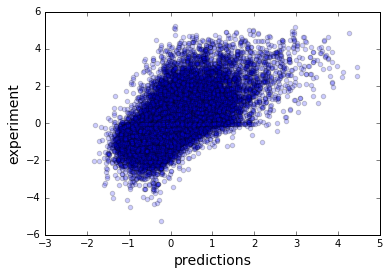

In [13]:
plt.figure()
plt.scatter(test_predict[:,0], Y_test[:,0], alpha=0.2)
plt.xlabel('predictions', fontsize=14)
plt.ylabel('experiment', fontsize=14)

# Let's generate a saliency map

To calculate a saliency map, we need to calculate the derivative of the output neuron with respect to the inputs.  Luckily, tensorflow makes this easy because it calculates gradients using automatic differentiation.  We can calculate the gradient with the function tf.gradients.  This method constructs partial derivatives of ys w.r.t. x in xs. ys and xs are each a Tensor or a list of tensors. 

tf.gradients(
    ys,
    xs,
    grad_ys=None,
    name='gradients',
    colocate_gradients_with_ops=False,
    gate_gradients=False,
    aggregation_method=None,
    stop_gradients=None
)

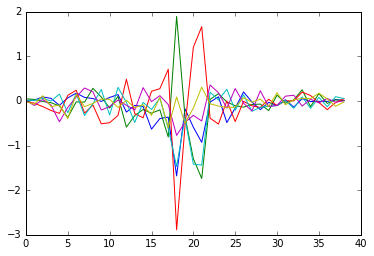

In [14]:
# let's get the highest predicted sequence 
max_index = np.argsort(test_predict[:,0])[::-1]

# get sequence
index = 1
X = np.expand_dims(X_test[max_index[index]], axis=0)

# calculate the gradients to the inputs
grad_to_inputs = tf.gradients(predictions, inputs)

# run the session to calculate the saliency map for a given sequence X
backprop_saliency = sess.run(grad_to_inputs, feed_dict={inputs: X, 
                                                        keep_prob_conv: 1.0, 
                                                        keep_prob_dense: 1.0})

plt.plot(np.squeeze(backprop_saliency[0]));

I've provided a visualization function to normalize the saliency map to be similar to a PWM and a function to plot a PWM as a sequence logo within the impress module.  

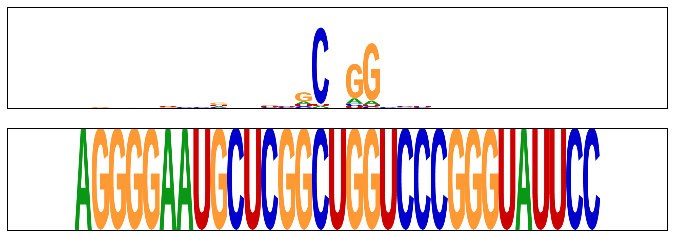

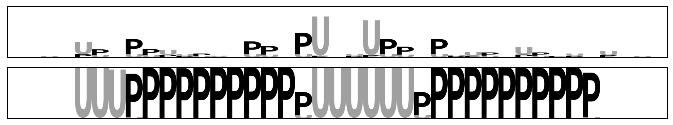

In [15]:
import impress

# filter and normalize saliency map 
norm_saliency = impress.normalize_pwm(np.squeeze(backprop_saliency[0]).T[:4,:], factor=3)

# generate sequence logo
logo = impress.seq_logo(norm_saliency, height=150, nt_width=50, norm=0, alphabet='rna')

seq = impress.seq_logo(np.squeeze(X).T[:4,:], height=150, nt_width=50, norm=0, alphabet='rna')

# plot sequence logo
plt.figure(figsize=(25,4))
plt.subplot(2,1,1)
plt.imshow(logo)
plt.xticks([]);
plt.yticks([]);
plt.subplot(2,1,2)
plt.imshow(seq)
plt.xticks([]);
plt.yticks([]);
                        
                        
# filter and normalize saliency map 
norm_saliency = impress.normalize_pwm(np.squeeze(backprop_saliency[0]).T[4:,:], factor=3)

# generate sequence logo
logo = impress.seq_logo(norm_saliency, height=150, nt_width=50, norm=0, alphabet='pu', colormap='bw')

seq = impress.seq_logo(np.squeeze(X).T[4:,:], height=150, nt_width=50, norm=0, alphabet='pu', colormap='bw')

# plot sequence logo
plt.figure(figsize=(25,2))
plt.subplot(2,1,1)
plt.imshow(logo)
plt.xticks([]);
plt.yticks([]);
plt.subplot(2,1,2)
plt.imshow(seq)
plt.xticks([]);
plt.yticks([]);
                        

# Where to go from here

###  official tutorials

https://www.tensorflow.org/tutorials/


### lower-level APIs

https://www.tensorflow.org/api_docs/python/tf/nn


### Layers 
    
https://www.tensorflow.org/api_docs/python/tf/layers
  
* tf.nn.layers.conv2d()
* tf.nn.layers.dense
* tf.nn.layers.dropout
* tf.nn.layers.max_pooling2d
* tf.nn.layers.batch_normalization


### alternative 

* tf.contrib.layers
* tf.keras.layers